Lambda School Data Science

*Unit 4, Sprint 3, Module 1*

---


# Recurrent Neural Networks (RNNs) and Long Short Term Memory (LSTM) (Prepare)

<img src="https://media.giphy.com/media/l2JJu8U8SoHhQEnoQ/giphy.gif" width=480 height=356>
<br></br>
<br></br>

## Learning Objectives
- <a href="#p1">Part 1: </a>Describe Neural Networks used for modeling sequences
- <a href="#p2">Part 2: </a>Apply a LSTM to a text generation problem using Keras


Additional Resources not in original finished notebook.

Weights and biases tutorial https://www.wandb.com/tutorials

Practical Applications of Open AI’s GPT-2 Deep Learning Model https://medium.com/the-research-nest/practical-applications-of-open-ais-gpt-2-deep-learning-model-14701f18a432#:~:text=GPT%2D2%20is%20a%20very,text%20samples%20of%20unprecedented%20quality

Papers with Code https://paperswithcode.com/

Illustrated guide to LSTM and GRU's https://www.youtube.com/watch?v=8HyCNIVRbSU

Illustrated Guide to Recurrent Neural Networks: Understanding the Intuition https://www.youtube.com/watch?v=LHXXI4-IEns


A Visual Guide to Recurrent Layers in Keras  https://amitness.com/2020/04/recurrent-layers-keras/


## Overview

> "Yesterday's just a memory - tomorrow is never what it's supposed to be." -- Bob Dylan

Wish you could save [Time In A Bottle](https://www.youtube.com/watch?v=AnWWj6xOleY)? With statistics you can do the next best thing - understand how data varies over time (or any sequential order), and use the order/time dimension predictively.

A sequence is just any enumerated collection - order counts, and repetition is allowed. Python lists are a good elemental example - `[1, 2, 2, -1]` is a valid list, and is different from `[1, 2, -1, 2]`. The data structures we tend to use (e.g. NumPy arrays) are often built on this fundamental structure.

A time series is data where you have not just the order but some actual continuous marker for where they lie "in time" - this could be a date, a timestamp, [Unix time](https://en.wikipedia.org/wiki/Unix_time), or something else. All time series are also sequences, and for some techniques you may just consider their order and not "how far apart" the entries are (if you have particularly consistent data collected at regular intervals it may not matter).

# Neural Networks for Sequences (Learn)

## Overview

There's plenty more to "traditional" time series, but the latest and greatest technique for sequence data is recurrent neural networks. A recurrence relation in math is an equation that uses recursion to define a sequence - a famous example is the Fibonacci numbers:

$F_n = F_{n-1} + F_{n-2}$

For formal math you also need a base case $F_0=1, F_1=1$, and then the rest builds from there. But for neural networks what we're really talking about are loops:

![Recurrent neural network](https://upload.wikimedia.org/wikipedia/commons/b/b5/Recurrent_neural_network_unfold.svg)

The hidden layers have edges (output) going back to their own input - this loop means that for any time `t` the training is at least partly based on the output from time `t-1`. The entire network is being represented on the left, and you can unfold the network explicitly to see how it behaves at any given `t`.

Different units can have this "loop", but a particularly successful one is the long short-term memory unit (LSTM):

![Long short-term memory unit](https://upload.wikimedia.org/wikipedia/commons/thumb/6/63/Long_Short-Term_Memory.svg/1024px-Long_Short-Term_Memory.svg.png)

There's a lot going on here - in a nutshell, the calculus still works out and backpropagation can still be implemented. The advantage (ane namesake) of LSTM is that it can generally put more weight on recent (short-term) events while not completely losing older (long-term) information.

After enough iterations, a typical neural network will start calculating prior gradients that are so small they effectively become zero - this is the [vanishing gradient problem](https://en.wikipedia.org/wiki/Vanishing_gradient_problem), and is what RNN with LSTM addresses. Pay special attention to the $c_t$ parameters and how they pass through the unit to get an intuition for how this problem is solved.

So why are these cool? One particularly compelling application is actually not time series but language modeling - language is inherently ordered data (letters/words go one after another, and the order *matters*). [The Unreasonable Effectiveness of Recurrent Neural Networks](https://karpathy.github.io/2015/05/21/rnn-effectiveness/) is a famous and worth reading blog post on this topic.

For our purposes, let's use TensorFlow and Keras to train RNNs with natural language. Resources:

- https://github.com/keras-team/keras/blob/master/examples/imdb_lstm.py
- https://keras.io/layers/recurrent/#lstm
- http://adventuresinmachinelearning.com/keras-lstm-tutorial/

Note that `tensorflow.contrib` [also has an implementation of RNN/LSTM](https://www.tensorflow.org/tutorials/sequences/recurrent).

## Follow Along

Sequences come in many shapes and forms from stock prices to text. We'll focus on text, because modeling text as a sequence is a strength of Neural Networks. Let's start with a simple classification task using a TensorFlow tutorial. 

### RNN/LSTM Sentiment Classification with Keras

In [1]:
'''
#Trains an LSTM model on the IMDB sentiment classification task.
The dataset is actually too small for LSTM to be of any advantage
compared to simpler, much faster methods such as TF-IDF + LogReg.
**Notes**
- RNNs are tricky. Choice of batch size is important,
choice of loss and optimizer is critical, etc.
Some configurations won't converge.
- LSTM loss decrease patterns during training can be quite different
from what you see with CNNs/MLPs/etc.
'''
from __future__ import print_function
import numpy as np
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Dropout, SimpleRNN, LSTM
from tensorflow.keras.datasets import imdb
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Set top N words and batch_size
max_features = 20000
batch_size = 32

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

# Map for readable classnames
class_names = ["Negative", "Positive"]

Loading data...
17465344/17464789 [==============================] - 14s 1us/step
25000 train sequences
25000 test sequences


Reviews in the IMDB dataset have been encoded as a sequence of integers. Luckily the dataset also contains an index for converting the reviews back into human readable form.

In [2]:
# Get the word index from the dataset
word_index = imdb.get_word_index()

# Ensure that "special" words are mapped into human readable terms 
word_index = {k:(v+3) for k,v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNKNOWN>"] = 2
word_index["<UNUSED>"] = 3

# Perform reverse word lookup and make it callable
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

1646592/1641221 [==============================] - 1s 0us/step


In [3]:
# Concatonate test and training datasets
allreviews = np.concatenate((x_train, x_test), axis=0)

# Review lengths across test and training whole datasets
print("Maximum review length: {}".format(len(max((allreviews), key=len))))
print("Minimum review length: {}".format(len(min((allreviews), key=len))))
result = [len(x) for x in allreviews]
print("Mean review length: {}".format(np.mean(result)))

# Print a review and it's class as stored in the dataset. Replace the number
# to select a different review.
print("")
print("Machine readable Review")
print("  Review Text: " + str(x_train[60]))
print("  Review Sentiment: " + str(y_train[60]))

# Print a review and it's class in human readable format. Replace the number
# to select a different review.
print("")
print("Human Readable Review")
print("  Review Text: " + decode_review(x_train[60]))
print("  Review Sentiment: " + class_names[y_train[60]])

Maximum review length: 2494
Minimum review length: 7
Mean review length: 234.75892

Machine readable Review
  Review Text: [1, 13, 219, 14, 33, 4, 12180, 22, 1413, 12, 16, 373, 175, 2711, 1115, 1026, 430, 939, 16, 23, 2444, 25, 43, 697, 89, 12, 16, 170, 8, 130, 262, 19, 32, 4, 665, 7, 4, 2, 322, 5, 4, 1520, 7, 4, 86, 250, 10, 10, 4, 249, 173, 16, 4, 3891, 6, 19, 4, 167, 564, 5, 564, 1325, 36, 805, 8, 216, 638, 17, 11076, 21, 25, 100, 376, 507, 4, 2110, 15, 79, 125, 23, 567, 13, 2134, 233, 36, 4852, 2, 5, 81, 1672, 10, 10, 92, 437, 129, 58, 13, 69, 8, 401, 61, 1432, 39, 1286, 46, 7, 12]
  Review Sentiment: 0

Human Readable Review
  Review Text: <START> i saw this at the edinburgh film festival it was awful every clichéd violent rich boy fantasy was on display you just knew how it was going to end especially with all the shots of the <UNKNOWN> wife and the rape of the first girl br br the worst part was the q a with the director writer and writer producer they tried to come across as in

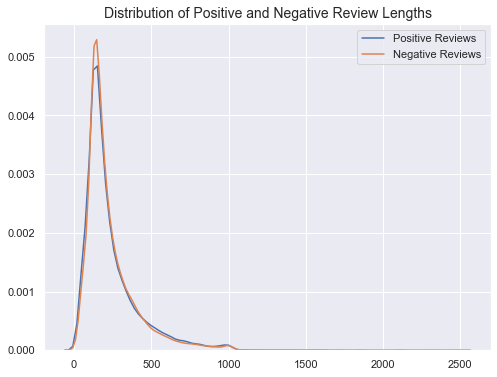

In [4]:
# Get the lengths for positive and negative reviews
all_labels = np.concatenate([y_train, y_test])
positive = np.array(result)[all_labels==1]
negative = np.array(result)[all_labels==0]

plt.figure(figsize=(8,6))
sns.distplot(positive, label='Positive Reviews', hist=False)
sns.distplot(negative, label='Negative Reviews', hist=False)
plt.title('Distribution of Positive and Negative Review Lengths', fontsize=14)
plt.legend();

In [5]:
# If you want to pad the end of the sequences you can set padding='post'.
maxlen = 300

print('Pad Sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape: ', x_train.shape)
print('x_test shape: ', x_test.shape)

Pad Sequences (samples x time)
x_train shape:  (25000, 300)
x_test shape:  (25000, 300)


In [6]:
x_train[60]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

Let's get a baseline performance for Multi-Layer Perceptron

In [ ]:
mlp = Sequential()
mlp.add(Embedding(max_features, 128))
mlp.add(Dense(128))
mlp.add(Dropout(0.25))
mlp.add(Dense(1, activation='sigmoid'))

mlp.compile(loss='binary_crossentropy',
              optimizer='adam', 
              metrics=['accuracy'])

mlp.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 128)         2560000   
_________________________________________________________________
dense (Dense)                (None, None, 128)         16512     
_________________________________________________________________
dropout (Dropout)            (None, None, 128)         0         
_________________________________________________________________
dense_1 (Dense)              (None, None, 1)           129       
Total params: 2,576,641
Trainable params: 2,576,641
Non-trainable params: 0
_________________________________________________________________


In [ ]:
mlp_history = mlp.fit(x_train, y_train,
                      batch_size=batch_size, 
                      epochs=5, 
                      validation_data=(x_test, y_test))

Epoch 1/5
782/782 [==============================] - 27s 35ms/step - loss: 0.6858 - accuracy: 0.5351 - val_loss: 0.6860 - val_accuracy: 0.5293
Epoch 2/5
782/782 [==============================] - 27s 34ms/step - loss: 0.6830 - accuracy: 0.5367 - val_loss: 0.6857 - val_accuracy: 0.5297
Epoch 3/5
782/782 [==============================] - 27s 34ms/step - loss: 0.6823 - accuracy: 0.5352 - val_loss: 0.6857 - val_accuracy: 0.5348
Epoch 4/5
782/782 [==============================] - 27s 35ms/step - loss: 0.6822 - accuracy: 0.5389 - val_loss: 0.6860 - val_accuracy: 0.5297
Epoch 5/5
782/782 [==============================] - 27s 35ms/step - loss: 0.6819 - accuracy: 0.5354 - val_loss: 0.6862 - val_accuracy: 0.5354


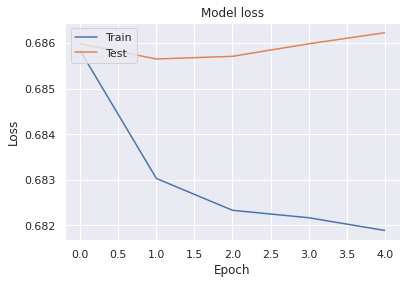

In [ ]:
# Plot training & validation loss values
plt.plot(mlp_history.history['loss'])
plt.plot(mlp_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show();

Let's try using the SimpleRNN layers instead of Dense

In [ ]:
rnn = Sequential()
rnn.add(Embedding(max_features, 128))
rnn.add(SimpleRNN(128))
rnn.add(Dropout(0.25))
rnn.add(Dense(1, activation='sigmoid'))

rnn.compile(loss='binary_crossentropy',
              optimizer='adam', 
              metrics=['accuracy'])

rnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 128)         2560000   
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 2,593,025
Trainable params: 2,593,025
Non-trainable params: 0
_________________________________________________________________


In [ ]:
rnn_history = mlp.fit(x_train, y_train,
                      batch_size=batch_size, 
                      epochs=5, 
                      validation_data=(x_test, y_test))

Epoch 1/5
782/782 [==============================] - 27s 35ms/step - loss: 0.6818 - accuracy: 0.5370 - val_loss: 0.6861 - val_accuracy: 0.5353
Epoch 2/5
782/782 [==============================] - 27s 34ms/step - loss: 0.6818 - accuracy: 0.5344 - val_loss: 0.6858 - val_accuracy: 0.5354
Epoch 3/5
782/782 [==============================] - 27s 34ms/step - loss: 0.6816 - accuracy: 0.5381 - val_loss: 0.6874 - val_accuracy: 0.5292
Epoch 4/5
782/782 [==============================] - 27s 34ms/step - loss: 0.6815 - accuracy: 0.5371 - val_loss: 0.6862 - val_accuracy: 0.5355
Epoch 5/5
782/782 [==============================] - 27s 34ms/step - loss: 0.6814 - accuracy: 0.5369 - val_loss: 0.6858 - val_accuracy: 0.5356


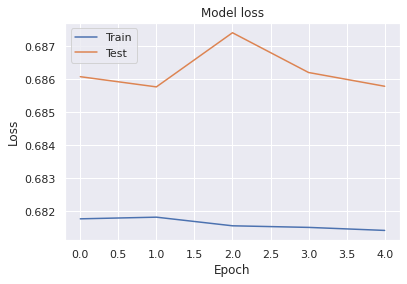

In [ ]:
# Plot training & validation loss values
plt.plot(rnn_history.history['loss'])
plt.plot(rnn_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show();

Lastly, Let's try replacing the SimpleRNN layer with LSTM.

In [ ]:
lstm = Sequential()
lstm.add(Embedding(max_features, 128))

# We are using a fast version of LSTM whih is optimised for GPUs. This layer 
# looks at the sequence of words in the review, along with their word embeddings
# and uses both of these to determine the sentiment of a given review.

# If you wanted to stack multiple LSTM layers:
# model.add(LSTM(256, return_sequences=True))
# model.add(LSTM(128))

# If you wanted to add Bidirectional LSTM:
# lstm.add(Bidirectional(LSTM(128)))

# Note for training on GPU:
# In TensorFlow 2.0, the built-in LSTM and GRU layers have been updated to leverage CuDNN kernels by default when a GPU is available. 
# With this change, the prior keras.layers.CuDNNLSTM/CuDNNGRU layers have been deprecated, and you can build your model without worrying 
# about the hardware it will run on.

lstm.add(LSTM(128))
lstm.add(Dropout(0.25))
lstm.add(Dense(1, activation='sigmoid'))

lstm.compile(loss='binary_crossentropy',
              optimizer='adam', 
              metrics=['accuracy'])

lstm.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, None, 128)         2560000   
_________________________________________________________________
lstm_8 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 129       
Total params: 2,691,713
Trainable params: 2,691,713
Non-trainable params: 0
_________________________________________________________________


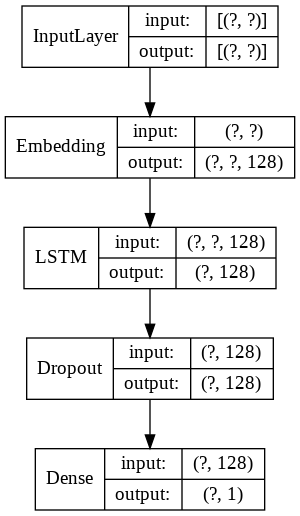

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(lstm, to_file='lstm.png', show_shapes=True, show_layer_names=False)

In [ ]:
lstm_history = lstm.fit(x_train, y_train,
                        batch_size=batch_size, 
                        epochs=5, 
                        validation_data=(x_test,y_test))

Epoch 1/5
782/782 [==============================] - 42s 54ms/step - loss: 0.4288 - accuracy: 0.8020 - val_loss: 0.3662 - val_accuracy: 0.8511
Epoch 2/5
782/782 [==============================] - 42s 54ms/step - loss: 0.2778 - accuracy: 0.8882 - val_loss: 0.3554 - val_accuracy: 0.8455
Epoch 3/5
782/782 [==============================] - 42s 54ms/step - loss: 0.1674 - accuracy: 0.9390 - val_loss: 0.3627 - val_accuracy: 0.8644
Epoch 4/5
782/782 [==============================] - 42s 53ms/step - loss: 0.1113 - accuracy: 0.9612 - val_loss: 0.5488 - val_accuracy: 0.7907
Epoch 5/5
782/782 [==============================] - 41s 53ms/step - loss: 0.1248 - accuracy: 0.9546 - val_loss: 0.4681 - val_accuracy: 0.8492


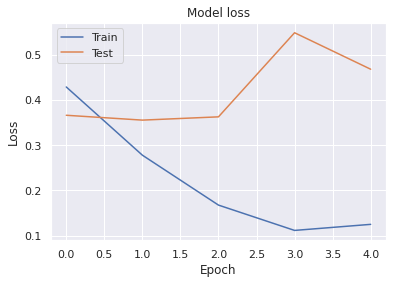

In [ ]:
# Plot training & validation loss values
plt.plot(lstm_history.history['loss'])
plt.plot(lstm_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show();

## Evaluate model with test data and view results

In [ ]:
# Get Model Predictions for test data
from sklearn.metrics import classification_report

predicted_classes = lstm.predict_classes(x_test)
print(classification_report(y_test, predicted_classes, target_names=class_names))

              precision    recall  f1-score   support

    Negative       0.85      0.85      0.85     12500
    Positive       0.85      0.85      0.85     12500

    accuracy                           0.85     25000
   macro avg       0.85      0.85      0.85     25000
weighted avg       0.85      0.85      0.85     25000



## View some incorrect predictions

Lets have a look at some of the incorrectly classified reviews. For readability we remove the padding.

In [ ]:
predicted_classes_reshaped = np.reshape(predicted_classes, 25000)
incorrect = np.nonzero(predicted_classes_reshaped != y_test)[0]

# We select the first 10 incorrectly classified reviews
for j, incorrect in enumerate(incorrect[0:3]):
    
    predicted = class_names[predicted_classes_reshaped[incorrect]]
    actual = class_names[y_test[incorrect]]
    human_readable_review = decode_review(x_test[incorrect])
    
    print("Incorrectly classified Test Review ["+ str(j+1) +"]") 
    print("Test Review #" + str(incorrect)  + ": Predicted ["+ predicted + "] Actual ["+ actual + "]")
    print("Test Review Text: " + human_readable_review.replace("<PAD> ", ""))
    print("")

Incorrectly classified Test Review [1]
Test Review #3: Predicted [Positive] Actual [Negative]
Test Review Text: <START> i generally love this type of movie however this time i found myself wanting to kick the screen since i can't do that i will just complain about it this was absolutely idiotic the things that happen with the dead kids are very cool but the alive people are absolute idiots i am a grown man pretty big and i can defend myself well however i would not do half the stuff the little girl does in this movie also the mother in this movie is reckless with her children to the point of neglect i wish i wasn't so angry about her and her actions because i would have otherwise enjoyed the flick what a number she was take my advise and fast forward through everything you see her do until the end also is anyone else getting sick of watching movies that are filmed so dark anymore one can hardly see what is being filmed as an audience we are impossibly involved with the actions on the s

## Run your own text against the trained model

In [7]:
# Write your own review
review = "this is the best film i have ever seen it is great and fantastic and i loved it"

# Encode review (replace word with integers)
tmp = []
for word in review.split(" "):
    tmp.append(word_index[word])

# Ensure review is 300 characters long (by padding or truncating)
tmp_padded = sequence.pad_sequences([tmp], maxlen=maxlen) 

# Run your processed review against the trained model
rawprediction = lstm.predict(np.array([tmp_padded][0]))[0][0]
prediction = int(round(rawprediction))

# Test the model and print the result
print("Review: " + review)
print("Raw Prediction: " + str(rawprediction))
print("Predicted Class: " + class_names[prediction])

NameError: name 'lstm' is not defined

## Challenge

You will be expected to use an Keras LSTM for a classicification task on the *Sprint Challenge*. 

Reference for some of the code in the section above can be found: https://github.com/markwest1972/LSTM-Example-Google-Colaboratory/blob/master/LSTM_IMDB_Sentiment_Example.ipynb

# LSTM Text generation with Keras (Learn)

## Overview

What else can we do with LSTMs? Since we're analyzing the *sequence*, we can do more than classify - we can *generate* text. I'ved pulled some news stories using [newspaper](https://github.com/codelucas/newspaper/).

This example is drawn from the Keras [documentation](https://keras.io/examples/lstm_text_generation/).

In [9]:
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import RMSprop

import pandas as pd
import numpy as np
import random
import sys
import os

In [10]:
# Washington Post articles from October 2019 collected by Jon-Cody Sokoll
url = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-4-Sprint-3-Deep-Learning/master/module1-rnn-and-lstm/wp_articles.json'

data = pd.read_json(url)
print(data.shape)
data.head()

(136, 1)


,article
0,Contributing columnist\n\nThe House is on fire...
1,When President Trump announced his decision to...
10,Russian President Vladimir Putin speaks at a s...
100,“The Queen’s Speech” is designed to acknowledg...
101,"Like an aging rock star, the president is now ..."


In [11]:
# Let's inspect the first article
data.article.values[0]

"Contributing columnist\n\nThe House is on fire. And with each passing day, Donald Trump defiles the office of the president. If only past defrocked presidents could provide a roadmap for this firestorm.\n\nAndrew Johnson fought impeachment vigorously and survived removal, but never won reelection. Richard Nixon got in the way of justice, but eventually bowed to the rule of law, accepting his asterisk in the annals of history and resigning before certain removal. Bill Clinton expressed contrition, went on to complete his presidency with high approval ratings and has remained a popular former president.\n\nIf you care about democracy, the rule of law and nearly 250 years of constitutional governance, take heed. President Trump is no Clinton or Nixon, or even Johnson. He will not go quietly. It will be ugly. He will betray us and the rule of law in the process — defying subpoenas, withholding documents, blocking witnesses.\n\nThis presidency is fouled with disrespect for rules, boundarie

In [12]:
# Encode Data as Chars

# Gather all text 
# Why? 
# 1. See all possible characters 
# 2. For training / splitting later
text = " ".join(data.article.values)

# Unique Characters
chars = list(set(text))

# Lookup Tables
char_int = {c:i for i, c in enumerate(chars)} 
int_char = {i:c for i, c in enumerate(chars)} 

In [15]:
text[:100]

'Contributing columnist\n\nThe House is on fire. And with each passing day, Donald Trump defiles the of'

In [17]:
chars[:5]

['A', '4', '\n', 'S', '"']

In [ ]:
len(chars)

121

In [ ]:
chars

['$',
 '@',
 'h',
 '[',
 'P',
 '🗣',
 'L',
 't',
 'ê',
 'j',
 'í',
 'e',
 '\u2069',
 'q',
 'l',
 'o',
 'Q',
 '5',
 'g',
 '#',
 'ó',
 'S',
 '-',
 '8',
 '6',
 '½',
 'r',
 'V',
 'Z',
 'U',
 '2',
 'W',
 'F',
 'i',
 'd',
 '👻',
 '–',
 '―',
 '%',
 '…',
 '7',
 'n',
 'ö',
 '\u2066',
 's',
 'é',
 'm',
 '\xad',
 'è',
 'A',
 '●',
 '"',
 '⭐',
 '’',
 'a',
 'O',
 'I',
 ',',
 'ñ',
 'Y',
 'y',
 '4',
 '&',
 "'",
 'K',
 'w',
 'C',
 'v',
 ')',
 'k',
 'X',
 '·',
 '+',
 'R',
 '×',
 'p',
 'D',
 '—',
 '_',
 '“',
 ']',
 '©',
 'T',
 'u',
 ':',
 'á',
 '⅔',
 'ﬂ',
 '1',
 '9',
 'B',
 '⅓',
 '|',
 '0',
 '”',
 '?',
 'f',
 ';',
 'G',
 '!',
 'b',
 'M',
 'x',
 '*',
 '{',
 'ã',
 'c',
 'z',
 'H',
 ' ',
 '\n',
 '.',
 '🤔',
 '(',
 'E',
 'N',
 'J',
 '‘',
 '•',
 '/',
 '3']

In [ ]:
# We may want to remove non-ASCII characters
data['article_clean'] = data['article'].replace({r'[^\x00-\x7F]+':''}, regex=True, inplace=True)

In [ ]:
# Encode Data as Chars

# Gather all text 
# Why? 
# 1. See all possible characters 
# 2. For training / splitting later
text = " ".join(data.article.values)

# Unique Characters
chars = list(set(text))

# Lookup Tables
char_int = {c:i for i, c in enumerate(chars)} 
int_char = {i:c for i, c in enumerate(chars)} 

In [ ]:
len(chars)

88

In [ ]:
chars

['$',
 '@',
 'h',
 '[',
 'P',
 'L',
 't',
 'j',
 'e',
 'q',
 'l',
 'o',
 'Q',
 '5',
 'g',
 '#',
 'S',
 '-',
 '8',
 '6',
 'r',
 'V',
 'Z',
 'U',
 '2',
 'W',
 'F',
 'i',
 'd',
 '%',
 '7',
 'n',
 's',
 'm',
 'A',
 '"',
 'a',
 'O',
 'I',
 ',',
 'Y',
 'y',
 '4',
 '&',
 "'",
 'K',
 'w',
 'C',
 'v',
 ')',
 'k',
 'X',
 '+',
 'R',
 'p',
 'D',
 '_',
 ']',
 'T',
 'u',
 ':',
 '1',
 '9',
 'B',
 '|',
 '0',
 '?',
 'f',
 ';',
 'G',
 '!',
 'b',
 'M',
 'x',
 '*',
 '{',
 'c',
 'z',
 'H',
 ' ',
 '\n',
 '.',
 '(',
 'E',
 'N',
 'J',
 '/',
 '3']

In [20]:
len(encoded)

891910

In [19]:
# Create the sequence data
maxlen = 40
step = 5

encoded = [char_int[c] for c in text]

sequences = [] # Each element is 40 chars long
next_char = [] # One element for each sequence

for i in range(0, len(encoded) - maxlen, step):
    
    sequences.append(encoded[i : i + maxlen])
    next_char.append(encoded[i + maxlen])
    
print('sequences: ', len(sequences))

sequences:  178374


In [ ]:
sequences[0]

[47,
 11,
 31,
 6,
 20,
 27,
 71,
 59,
 6,
 27,
 31,
 14,
 79,
 76,
 11,
 10,
 59,
 33,
 31,
 27,
 32,
 6,
 80,
 80,
 58,
 2,
 8,
 79,
 78,
 11,
 59,
 32,
 8,
 79,
 27,
 32,
 79,
 11,
 31,
 79]

In [ ]:
# Create x & y
x = np.zeros((len(sequences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sequences), len(chars)), dtype=np.bool)

for i, sequence in enumerate(sequences):
    for t, char in enumerate(sequence):
        x[i,t,char] = 1
        
    y[i, next_char[i]] = 1

In [ ]:
# What do the dimensions of x represent?
# Number of sequences, sequence length, unique characters
x.shape

(176992, 40, 88)

In [ ]:
# What about y?
y.shape

(176992, 88)

In [ ]:
# Build the model: a single LSTM
model = Sequential()
model.add(LSTM(128, input_shape=(maxlen, len(chars))))
model.add(Dense(len(chars), activation='softmax'))

# Compile
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [ ]:
def sample(preds):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / 1
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [ ]:
def on_epoch_end(epoch, _):
    # Function invoked at end of each epoch. Prints generated text.
    
    print()
    print('----- Generating text after Epoch: %d' % epoch)
    
    start_index = random.randint(0, len(text) - maxlen - 1)
    
    generated = ''
    
    # sentence = text[start_index: start_index + maxlen]
    sentence = 'President Trump recently had a confident'
    generated += sentence
    
    print('----- Generating with seed: "' + sentence + '"')
    sys.stdout.write(generated)
    
    for i in range(400):
        x_pred = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(sentence):
            x_pred[0, t, char_int[char]] = 1
            
        preds = model.predict(x_pred, verbose=0)[0]
        next_index = sample(preds)
        next_char = int_char[next_index]
        
        sentence = sentence[1:] + next_char
        
        sys.stdout.write(next_char)
        sys.stdout.flush()
    print()


print_callback = LambdaCallback(on_epoch_end=on_epoch_end)

In [ ]:
# fit the model
model.fit(x, y,
          batch_size=32,
          epochs=25,
          callbacks=[print_callback])

Epoch 1/25
5528/5531 [============================>.] - ETA: 0s - loss: 2.5215
----- Generating text after Epoch: 0
----- Generating with seed: "President Trump recently had a confident"
President Trump recently had a confident calsilang plomm porit wh desape il Whuch gremtateel perllutir Walebtove that has likilt. Thoutsile ally sellionge ssuelnce nastinntalis leon that dofes.

Y-she the hain meichise byous, thoe anster Plakint of the fouth. Progife corvame io intin lagted and phereifs sray beush walspentings as geatel ringrict the p usence Sther tho the pullect Is inetins. Sreising. Tal thes ypes, an sack pontsiin the
5531/5531 [==============================] - 39s 7ms/step - loss: 2.5213
Epoch 2/25
5529/5531 [============================>.] - ETA: 0s - loss: 2.1758
----- Generating text after Epoch: 1
----- Generating with seed: "President Trump recently had a confident"
President Trump recently had a confident of leve that daden for prile treia rereate a poncion the ont ald regule

## Challenge

You will be expected to use a Keras LSTM to generate text on today's assignment. 

# Review

- <a href="#p1">Part 1: </a>Describe Neural Networks used for modeling sequences
    * Sequence Problems:
        - Time Series (like Stock Prices, Weather, etc.)
        - Text Classification
        - Text Generation
        - And many more! :D
    * LSTMs are generally preferred over RNNs for most problems
    * LSTMs are typically a single hidden layer of LSTM type; although, other architectures are possible.
    * Keras has LSTMs/RNN layer types implemented nicely
- <a href="#p2">Part 2: </a>Apply a LSTM to a text generation problem using Keras
    * Shape of input data is very important
    * Can take a while to train
    * You can use it to write movie scripts. :P 